The purpose of this data science project is to come up with a predictive model for pothole location while utilizing the existing pothole data and weather forecast data. If potholes could be predicted it could allow for better planning for commuters and also better planning for the city to distribute resources more effectively. The City of Houston has a next day policy for pothole repairs. 

# Data Wrangling

## Imports

Importing used dependencies

In [126]:
#Import pandas, matplotlib.pyplot, and seaborn in the correct lines below
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime as dt
import time
import seaborn as sns
from scipy import stats

## Objectives

* Do you think you may have the data you need to tackle the desired question?
    * Have you identified the required target value?
    * Do you have potentially useful features?
* Do you have any fundamental issues with the data?

## Loading Pothole Data

In [2]:
# The pothole data is supplied by the City of Houston Pothole record site. It is broken down into years. Iterating through
# years and appending a Pandas table should populate the data
pothole_years = [datayear for datayear in range(2011,dt.date.today().year +1)]
pothole_URL_list = ['https://hfdapp.houstontx.gov/311/311-Public-Data-Extract-' + str(year) + '-clean.txt' for year in pothole_years]
start = time.time()
pothole_df_list = [pd.read_csv(url,sep = "|",error_bad_lines=False, index_col=0) for url in pothole_URL_list]
end = time.time()
print(end - start)

b'Skipping line 99736: expected 29 fields, saw 30\n'
b'Skipping line 142010: expected 29 fields, saw 30\nSkipping line 142599: expected 29 fields, saw 30\nSkipping line 153313: expected 29 fields, saw 30\n'
b'Skipping line 191143: expected 29 fields, saw 30\nSkipping line 193671: expected 29 fields, saw 30\n'
b'Skipping line 207631: expected 29 fields, saw 30\nSkipping line 219597: expected 29 fields, saw 30\nSkipping line 225109: expected 29 fields, saw 30\n'
b'Skipping line 277039: expected 29 fields, saw 30\n'
b'Skipping line 78774: expected 29 fields, saw 31\n'
b'Skipping line 105843: expected 29 fields, saw 30\n'
b'Skipping line 134105: expected 29 fields, saw 30\n'
b'Skipping line 168993: expected 29 fields, saw 30\n'
b'Skipping line 198472: expected 29 fields, saw 30\nSkipping line 220143: expected 29 fields, saw 30\n'
b'Skipping line 272900: expected 29 fields, saw 30\nSkipping line 282458: expected 29 fields, saw 30\n'
b'Skipping line 339869: expected 29 fields, saw 31\nSkippi

264.2061769962311


In [3]:
#Create set of years and pothole df's to create one dictionary
pothole_df_sets = zip(pothole_years,pothole_df_list)
pothole_df_dict = dict(pothole_df_sets)

In [4]:
#confirm keys of dicitionary of pothole dataframes
pothole_df_dict.keys()

dict_keys([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [5]:
#visualize dataframe shapes in a dictionary 
{year : pothole_df_dict[year].shape for year in pothole_years}

{2011: (35072, 28),
 2012: (294752, 28),
 2013: (313220, 28),
 2014: (321929, 28),
 2015: (343633, 28),
 2016: (361308, 28),
 2017: (364664, 28),
 2018: (399952, 28),
 2019: (395257, 28),
 2020: (373117, 28),
 2021: (172550, 28)}

The same number of columns for all imported pothole dataframes

In [6]:
#Calculate total number of rows across all dataframes
totalrows_pothole = sum([pothole_df_dict[year].shape[0] for year in pothole_years])
print(totalrows_pothole)
#29 rows skipped
29/totalrows_pothole * 100

3375454


0.0008591436885230846

0.0009% of the rows were skipped due to parsing issues where an incorrect number of fields were brought in than expected. This percentage is acceptable to move forward. 

In [7]:
#Find if there are differences in headers between each pothole df
header_lists = [pothole_df_dict[year].columns for year in pothole_years]
column_compare = [set(header_lists[x]).difference(set(header_lists[x+1])) for x in range(len(pothole_years)-1)]
column_compare

[set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]

All headers appear the same. 

In [8]:
#Check that data types are the same across pothole df's
dtypes_lists = [pothole_df_dict[year].dtypes for year in pothole_years]
dtypes_compare = [set(dtypes_lists[x]).difference(set(dtypes_lists[x+1])) for x in range(len(pothole_years)-1)]
dtypes_compare

[set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]

All data types for each pothole dataframe appear the same. 

In [9]:
#Pothole dataframe combination
pothole_total_df_raw = pd.concat(pothole_df_list,axis=0)
pothole_total_df_raw.shape

(3375454, 28)

Total rows of combined pothole dataframes equals the sum of the individual dataframes. This give confidence that the rows properly merged. 

## Loading Weather Data

In [10]:
# The weather data comes from 24 stations around the greater Houston area. A quick glance at the site showed various levels of
# data collection and varying dates of records starting. Data will be limited to the range of 1/1/2011 to present day to
# correlate with the pothole tracking start date

weather_stations_list = ['USC00414327', 'US1ARPY0002', 'USC00224265', 'USW00012977', 'US1MOFSA215', 'CA001073615', 'US1MOTX0041',
                       'US1TXHRR176', 'USC00234019', 'US1MOTX0007', 'USW00053910', 'US1TXHRR147', 'USC00414325', 'US1TXHRR165',
                       'USC00503731', 'US1TXHRR269', 'USW00012918', 'US1OHSH0011', 'USC00414333', 'US1MOTX0040', 'US1TXHRR209',
                       'USW00012960', 'USW00012975', 'US1TXHRR232']
weather_stations_URL_list = ['https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=' 
                             + station 
                             + '&startDate=2011-01-01&endDate=2020-11-01&units=standard' for station in weather_stations_list]
weather_stations_df_list = [pd.read_csv(url,usecols = ['STATION','DATE','PRCP','TAVG','TMAX','TMIN','TOBS']) for url in weather_stations_URL_list]

In [11]:
#Check shape of one of the weather df's
weather_stations_df_list[0].shape

(3435, 7)

In [12]:
#Create set of stations and weather df's to create one dictionary
weather_df_sets = zip(weather_stations_list,weather_stations_df_list)
weather_df_dict = dict(weather_df_sets)

In [13]:
#confirm keys of dicitionary of weather dataframes
print(weather_df_dict.keys())
len(weather_df_dict.keys())

dict_keys(['USC00414327', 'US1ARPY0002', 'USC00224265', 'USW00012977', 'US1MOFSA215', 'CA001073615', 'US1MOTX0041', 'US1TXHRR176', 'USC00234019', 'US1MOTX0007', 'USW00053910', 'US1TXHRR147', 'USC00414325', 'US1TXHRR165', 'USC00503731', 'US1TXHRR269', 'USW00012918', 'US1OHSH0011', 'USC00414333', 'US1MOTX0040', 'US1TXHRR209', 'USW00012960', 'USW00012975', 'US1TXHRR232'])


24

In [14]:
#visualize dataframe shapes in a dictionary 
{station : weather_df_dict[station].shape for station in weather_stations_list}

{'USC00414327': (3435, 7),
 'US1ARPY0002': (2673, 7),
 'USC00224265': (2296, 7),
 'USW00012977': (3592, 7),
 'US1MOFSA215': (3286, 7),
 'CA001073615': (3277, 7),
 'US1MOTX0041': (279, 7),
 'US1TXHRR176': (2711, 7),
 'USC00234019': (3516, 7),
 'US1MOTX0007': (3580, 7),
 'USW00053910': (3592, 7),
 'US1TXHRR147': (1387, 7),
 'USC00414325': (3593, 7),
 'US1TXHRR165': (1883, 7),
 'USC00503731': (2093, 7),
 'US1TXHRR269': (407, 7),
 'USW00012918': (3593, 7),
 'US1OHSH0011': (3376, 7),
 'USC00414333': (3593, 7),
 'US1MOTX0040': (1317, 7),
 'US1TXHRR209': (2283, 7),
 'USW00012960': (3593, 7),
 'USW00012975': (3591, 7),
 'US1TXHRR232': (1501, 7)}

The same number of columns for all imported weather dataframes

In [15]:
#Calculate total number of rows across all dataframes
totalrows_weather = sum([weather_df_dict[station].shape[0] for station in weather_stations_list])
print(totalrows_weather)

64447


In [16]:
#Weather dataframe combination
weather_total_df_raw = pd.concat(weather_stations_df_list,axis=0)
weather_total_df_raw.shape

(64447, 7)

## Explore The Data and Cleaning

### Exploring the Data (Pothole)

In [17]:
#Explore the columns and initial data of the potholes
pothole_total_df_raw.head()

,SR LOCATION,COUNTY,DISTRICT,NEIGHBORHOOD,TAX ID,TRASH QUAD,RECYCLE QUAD,TRASH DAY,HEAVY TRASH DAY,RECYCLE DAY,...,SR CREATE DATE,DUE DATE,DATE CLOSED,OVERDUE,Title,x,y,LATITUDE,LONGITUDE,Channel Type
CASE NUMBER,,,,,,,,,,,,,,,,,,,,,
1100329481-101000461231,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,2011-11-09 01:24:57,2011-12-19 01:24:57,2011-12-29 20:33:19,10.80,Investigate minor main line break,NaN,NaN,Unknown,Unknown,Unknown
1100329484-101000461236,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,2011-11-09 02:12:52,2011-12-19 02:12:52,2011-12-29 20:33:53,10.76,Investigate minor main line break,NaN,NaN,Unknown,Unknown,Unknown
101000451923,"611 WALKER, HOUSTON TX 77002",Harris,I,DOWNTOWN,0010890000001,NaN,NaN,NaN,NaN,NaN,...,2011-11-09 05:15:37,2011-11-24 05:15:33,2011-11-09 05:28:13,-14.99,Contact Forestry to request a tree to plant in...,NaN,NaN,29.75989828,-95.36705705,Voice In
101000451924,"611 WALKER, HOUSTON TX 77002",Harris,I,DOWNTOWN,0010890000001,NaN,NaN,NaN,NaN,NaN,...,2011-11-09 05:17:50,2011-11-24 05:17:49,2011-11-09 05:28:02,-14.99,Contact Forestry to request a tree to plant in...,NaN,NaN,29.75989828,-95.36705705,Voice In
101000451925,"TEST, TEST",NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2011-11-09 05:28:52,2011-11-24 05:28:51,2012-10-23 10:21:29,334.20,Contact Forestry to request a tree to plant in...,NaN,NaN,NaN,NaN,Voice In


In [18]:
#Explore the columns
pothole_total_df_raw.columns

Index(['SR LOCATION', 'COUNTY', 'DISTRICT', 'NEIGHBORHOOD', 'TAX ID',
       'TRASH QUAD', 'RECYCLE QUAD', 'TRASH DAY', 'HEAVY TRASH DAY',
       'RECYCLE DAY', 'KEY MAP', 'MANAGEMENT DISTRICT', 'DEPARTMENT',
       'DIVISION', 'SR TYPE', 'QUEUE', 'SLA', 'STATUS', 'SR CREATE DATE',
       'DUE DATE', 'DATE CLOSED', 'OVERDUE', 'Title', 'x', 'y', 'LATITUDE',
       'LONGITUDE', 'Channel Type'],
      dtype='object')

In [19]:
#Check data types
pothole_total_df_raw.dtypes

SR LOCATION             object
COUNTY                  object
DISTRICT                object
NEIGHBORHOOD            object
TAX ID                  object
TRASH QUAD              object
RECYCLE QUAD            object
TRASH DAY               object
HEAVY TRASH DAY         object
RECYCLE DAY             object
KEY MAP                 object
MANAGEMENT DISTRICT     object
DEPARTMENT              object
DIVISION                object
SR TYPE                 object
QUEUE                   object
SLA                    float64
STATUS                  object
SR CREATE DATE          object
DUE DATE                object
DATE CLOSED             object
OVERDUE                float64
Title                   object
x                      float64
y                      float64
LATITUDE                object
LONGITUDE               object
Channel Type            object
dtype: object

 - DUE DATE, DATE CLOSED, and ST CREATE DATE will need to be converted to datetime format. 
 - Latitude and Longitude will need to be converted to float.

In [20]:
#Check for the number of missing data for each column
missing = pd.concat([pothole_total_df_raw.isnull().sum(), 100 * pothole_total_df_raw.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
MANAGEMENT DISTRICT,1878212,55.643241
TRASH DAY,1003511,29.729660
RECYCLE DAY,828677,24.550090
RECYCLE QUAD,820710,24.314063
HEAVY TRASH DAY,805049,23.850095
TRASH QUAD,800144,23.704782
TAX ID,659322,19.532839
y,358430,10.618720
x,358430,10.618720
LATITUDE,86288,2.556338


Target values for this dataset will be location columns. 
Therefore we can remove MANAGEMENT DISTRICT, TRASH DAY, RECYCLE DAY, RECYCLE QUAD, KEY MAP, HEAVY TRASH DAY, TRASH QUAD, TAX ID, Y, and X since these have many missing values and also are not needed. 

#### Description of channels

* Column: Description
* CASE_NUMBER: Unique case ID
* Caller_CITY: Caller's City
* Caller_STATE: Caller's State
* Caller_ZIP: Caller's Zip
* SR_LOCATION: The location the service request is being called in for
* COUNTY: The county of the service request
* DISTRICT: The geocoded Council district of the service request
* NEIGHBORHOOD: The neighborhood of the geocoded service request
* TAX_ID: The HCAD property tax ID for the service request
* SERVICE_AREA: 
* KEY_MAP: Key map of the service request
* MANAGEMENT_DISTRICT: The management district of the service request location
* TRASH_DAY: The trash day of the service request location
* HEAVY_TRASH_DAY: The heavy trash day of the service request location
* RECYCLE_DAY: The recycling day of the service request location
* SR_CREATOR: The creator of the service request 
* DEPARTMENT: The department the service request is directed to (could be virtual department, e.g. 311 Help Line)
* DIVISION: The division the service request is directed to (e.g. Knowledge)
* SR_TYPE: The service request type
* QUEUE: The queue the service request is put into
* SLA: The service level agreement days. The number of days the department has from the create date to address the service request
* STATUS: Status of the service request. Closed does not necessarily mean the SR was solved to meet citizen needs.
* SR_CREATE_DATE: The create date of the service request
* DUE_DATE: The due date of the service request based on the SLA days
* DATE_CLOSED: The date the service request is closed
* OVERDUE: If the number is negative, it means the number days the service request was completed before the SLA was due (or, how many days are remaining to the SLA if the case is still open). If positive, it means the number of days the service request was complete after the SLA was due (or, how many days past the SLA if the case is still outstanding)
* x: The ESRI projection system X of the service request; this X is the best guess based on the P&D address points available at the time the service request was created
* y: The ESRI projection system Y of the service request; this Y is a the best guess based on the P&D address points available at the time the service request was created
* LATITUDE: Decimal Degrees longitude
* LONGITUDE: Decimal Degrees longitude
* Channel Type: How the ticket came in



In [21]:
#Check ST Types to make sure only pothole data is present
pothole_total_df_raw['SR TYPE'].value_counts()

Container Problem                  212366
Nuisance On Property               210972
Missed Garbage Pickup              191405
Water Leak                         173840
Sewer Wastewater                   159820
                                    ...  
Open Records                            2
Curb Repair due to Utility Work         2
Water Shortage Violation                1
Driveway Replacement                    1
Pothole (App_Serv)                      1
Name: SR TYPE, Length: 290, dtype: int64

In [22]:
#Check to see how many Service Request Types are pothole related. The rest are not needed as they are for another service
SR_pothole = pothole_total_df_raw['SR TYPE'].str.lower()
SR_pothole.str.contains('pothole').sum()

64505

### Cleaning the Data (Pothole)

#### Checking for Inconsistencies and Removing Unnecessary Columns

In [23]:
#Create a copy of the pothole df to leave the original intact 
pothole_df_scrub = pothole_total_df_raw

In [24]:
#Limit to ST Type equal to pothole for only pothole information
pothole_df_scrub = pothole_df_scrub[pothole_df_scrub['SR TYPE'] == 'Pothole']

In [25]:
print(pothole_df_scrub.shape)
pothole_df_scrub.head()

(64387, 28)


,SR LOCATION,COUNTY,DISTRICT,NEIGHBORHOOD,TAX ID,TRASH QUAD,RECYCLE QUAD,TRASH DAY,HEAVY TRASH DAY,RECYCLE DAY,...,SR CREATE DATE,DUE DATE,DATE CLOSED,OVERDUE,Title,x,y,LATITUDE,LONGITUDE,Channel Type
CASE NUMBER,,,,,,,,,,,,,,,,,,,,,
11433929-101000452108,Intersection 13500 S POST OAK RD & 5400 WILLOM...,Harris County,K,CENTRAL SOUTHWEST,NaN,NaN,NaN,NaN,NaN,NaN,...,2011-11-09 06:49:13,2011-11-19 06:49:12,2011-11-22 09:26:28,3.11,Pothole,3.091633e+06,1.379371e+07,29.63033251,-95.46407063,Voice In
11433959-101000452225,"8142 BONNER, HOUSTON TX 77017",HARRIS,I,MEADOWBROOK / ALLENDALE,0591820220008,SE,SE,MONDAY,1st Monday,MONDAY-B,...,2011-11-09 08:55:49,2011-11-19 08:55:49,2011-12-01 09:20:03,12.02,Pothole,3.154563e+06,1.381395e+07,29.6805785,-95.26404703,Voice In
11455803-101000452382,"875 LOCKWOOD, HOUSTON TX 77020",Harris,B,GREATER FIFTH WARD,0402630000023,NaN,NaN,NaN,NaN,NaN,...,2011-11-09 10:32:12,2011-11-19 10:32:11,2012-01-25 11:25:38,67.04,Pothole,3.136677e+06,1.384265e+07,29.76103454,-95.31750208,Voice In
11434023-101000452387,"875 LOCKWOOD, HOUSTON TX 77020",Harris,B,GREATER FIFTH WARD,0402630000023,NaN,NaN,NaN,NaN,NaN,...,2011-11-09 10:35:11,2011-11-19 10:35:10,2011-11-29 12:49:13,10.09,Pothole,3.136677e+06,1.384265e+07,29.76103454,-95.31750208,Voice In
11434047-101000452444,"12501 BRIAR FOREST, HOUSTON TX 77077",HARRIS,G,BRIAR FOREST,0992570020007,NaN,NaN,NaN,NaN,NaN,...,2011-11-09 11:09:56,2011-11-19 11:09:56,2011-11-29 13:00:17,10.08,Pothole,3.046384e+06,1.383720e+07,29.75355695,-95.60246727,Voice In


#### Check for the uniqueness of each column

In [26]:
#Visualize the different forms of the entries of County. Not needed yet but in case this column is needed, can adjust at the time. 
pothole_df_scrub['COUNTY'].str.lower().unique()

array(['harris county', 'harris', nan, 'unknown', 'fort bend county',
       'fort bend', 'montgomery county', 'montgomery', 'galveston county',
       'brazoria county'], dtype=object)

In [27]:
pothole_df_scrub.DEPARTMENT.str.lower().unique()

array(['pwe public works engineering'], dtype=object)

In [28]:
pothole_df_scrub.DISTRICT.str.lower().unique()

array(['k', 'i', 'b', 'g', 'unknown', 'f', 'c', 'a', 'j', 'd', 'h', 'e',
       nan], dtype=object)

In [29]:
pothole_df_scrub.Title.str.lower().unique()

array(['pothole', nan, 'pothole - 1362', ..., 'pothole - 459957',
       'pothole - 459981', 'pothole - 460022'], dtype=object)

In [30]:
pothole_df_scrub.DIVISION.str.lower().unique()

array(['street and drainage'], dtype=object)

In [31]:
pothole_df_scrub.SLA.unique()

array([18.])

In [32]:
pothole_df_scrub.QUEUE.str.lower().unique()

array(['rowm_streetmain', 'hpw_complaints', 'no queue assigned to user',
       'pu_water', 'defectivecase', 'cao_potholerescontact',
       '311_helpline'], dtype=object)

In [33]:
pothole_df_scrub.NEIGHBORHOOD.str.lower().unique()

array(['central southwest', 'meadowbrook / allendale',
       'greater fifth ward', 'briar forest', nan, 'alief',
       'meyerland area', 'clinton park tri-community',
       'eldridge / west oaks', 'university place', 'greater inwood',
       'neartown - montrose', 'trinity / houston gardens', 'unknown',
       'sharpstown', 'braeburn', 'westchase', 'spring branch east',
       'fairbanks / northwest crossing', 'greater third ward',
       'greater eastwood', 'south main', 'central northwest',
       'washington avenue coalition / memorial p',
       'greenway / upper kirby area', 'south belt / ellington',
       'afton oaks / river oaks area', 'golfcrest / bellfort / reveille',
       'sunnyside', 'brays oaks', 'addicks park ten', 'midtown',
       'clear lake', 'greater heights', 'downtown',
       'greater ost / south union', 'acres home', 'greater uptown',
       'iah / airport area', 'spring branch central', 'minnetex',
       'braeswood', 'denver harbor / port houston', 'norths

#### Begin Data Cleaning...

In [34]:
# Drop extraneous columns and columns filled with a larger percentage of missing values
pothole_df_scrubbed = pothole_df_scrub.drop(columns = ['MANAGEMENT DISTRICT','TRASH DAY','RECYCLE DAY','HEAVY TRASH DAY','TRASH QUAD','x','y','Channel Type',
                                  'TAX ID','KEY MAP','RECYCLE QUAD','DEPARTMENT','Channel Type','DISTRICT','Title','DIVISION',
                                                       'SLA'])
print(pothole_df_scrubbed.shape)
print(pothole_df_scrubbed.columns)

(64387, 12)
Index(['SR LOCATION', 'COUNTY', 'NEIGHBORHOOD', 'SR TYPE', 'QUEUE', 'STATUS',
       'SR CREATE DATE', 'DUE DATE', 'DATE CLOSED', 'OVERDUE', 'LATITUDE',
       'LONGITUDE'],
      dtype='object')


Since Longitude and Latitude are needed for the analysis, if a record does not have that information, it will be dropped

In [35]:
#Check types again to make adjustments
pothole_df_scrubbed.dtypes

SR LOCATION        object
COUNTY             object
NEIGHBORHOOD       object
SR TYPE            object
QUEUE              object
STATUS             object
SR CREATE DATE     object
DUE DATE           object
DATE CLOSED        object
OVERDUE           float64
LATITUDE           object
LONGITUDE          object
dtype: object

In [36]:
#Convert date columns of interest to datetime formats, convert Latitude/Longitude to float
pothole_df_scrubbed[['DUE DATE','DATE CLOSED','SR CREATE DATE']] = pothole_df_scrubbed[['DUE DATE','DATE CLOSED','SR CREATE DATE']].astype('datetime64')
pothole_df_scrubbed['LONGITUDE'] = pd.to_numeric(pothole_df_scrubbed['LONGITUDE'],errors='coerce')
pothole_df_scrubbed['LATITUDE'] = pd.to_numeric(pothole_df_scrubbed['LATITUDE'],errors='coerce')

In [37]:
#Check once again for missing data
missing = pd.concat([pothole_df_scrubbed.isnull().sum(), 100 * pothole_df_scrubbed.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
LATITUDE,3904,6.063336
LONGITUDE,3904,6.063336
COUNTY,2740,4.255517
NEIGHBORHOOD,2056,3.193191
SR LOCATION,1562,2.425956
DATE CLOSED,157,0.243838
SR TYPE,0,0.000000
QUEUE,0,0.000000
STATUS,0,0.000000
SR CREATE DATE,0,0.000000


In [38]:
#Remove columns where no latitude data is present
pothole_df_scrubbed = pothole_df_scrubbed[~pothole_df_scrubbed.LATITUDE.isnull()]
pothole_df_scrubbed.shape

(60483, 12)

In [39]:
#Re-check columns for missing data
missing = pd.concat([pothole_df_scrubbed.isnull().sum(), 100 * pothole_df_scrubbed.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
NEIGHBORHOOD,1800,2.976043
COUNTY,1250,2.066696
DATE CLOSED,155,0.256270
SR LOCATION,0,0.000000
SR TYPE,0,0.000000
QUEUE,0,0.000000
STATUS,0,0.000000
SR CREATE DATE,0,0.000000
DUE DATE,0,0.000000
OVERDUE,0,0.000000


In [40]:
pothole_df_scrubbed.shape

(60483, 12)

The rest of the null values in neighborhood, SR Location, County, and Date Closed won't affect the occurrences of the pothole so they can be left in but noted. If their values are needed, they can be identified later from the longitude and latitude. 

In [41]:
pothole_df_scrubbed.dtypes

SR LOCATION               object
COUNTY                    object
NEIGHBORHOOD              object
SR TYPE                   object
QUEUE                     object
STATUS                    object
SR CREATE DATE    datetime64[ns]
DUE DATE          datetime64[ns]
DATE CLOSED       datetime64[ns]
OVERDUE                  float64
LATITUDE                 float64
LONGITUDE                float64
dtype: object

In [42]:
# Review CLeaned Data
pothole_df_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60483 entries, 11433929-101000452108 to 12465198-101004716626
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SR LOCATION     60483 non-null  object        
 1   COUNTY          59233 non-null  object        
 2   NEIGHBORHOOD    58683 non-null  object        
 3   SR TYPE         60483 non-null  object        
 4   QUEUE           60483 non-null  object        
 5   STATUS          60483 non-null  object        
 6   SR CREATE DATE  60483 non-null  datetime64[ns]
 7   DUE DATE        60483 non-null  datetime64[ns]
 8   DATE CLOSED     60328 non-null  datetime64[ns]
 9   OVERDUE         60483 non-null  float64       
 10  LATITUDE        60483 non-null  float64       
 11  LONGITUDE       60483 non-null  float64       
dtypes: datetime64[ns](3), float64(3), object(6)
memory usage: 6.0+ MB


In [43]:
#Create date column that is just the date of SR Create Data without time
pothole_df_scrubbed['DATE'] = pothole_df_scrubbed['SR CREATE DATE'].dt.date
pothole_df_scrubbed.head()

,SR LOCATION,COUNTY,NEIGHBORHOOD,SR TYPE,QUEUE,STATUS,SR CREATE DATE,DUE DATE,DATE CLOSED,OVERDUE,LATITUDE,LONGITUDE,DATE
CASE NUMBER,,,,,,,,,,,,,
11433929-101000452108,Intersection 13500 S POST OAK RD & 5400 WILLOM...,Harris County,CENTRAL SOUTHWEST,Pothole,ROWM_StreetMain,Closed,2011-11-09 06:49:13,2011-11-19 06:49:12,2011-11-22 09:26:28,3.11,29.630333,-95.464071,2011-11-09
11433959-101000452225,"8142 BONNER, HOUSTON TX 77017",HARRIS,MEADOWBROOK / ALLENDALE,Pothole,ROWM_StreetMain,Closed,2011-11-09 08:55:49,2011-11-19 08:55:49,2011-12-01 09:20:03,12.02,29.680578,-95.264047,2011-11-09
11455803-101000452382,"875 LOCKWOOD, HOUSTON TX 77020",Harris,GREATER FIFTH WARD,Pothole,ROWM_StreetMain,Closed,2011-11-09 10:32:12,2011-11-19 10:32:11,2012-01-25 11:25:38,67.04,29.761035,-95.317502,2011-11-09
11434023-101000452387,"875 LOCKWOOD, HOUSTON TX 77020",Harris,GREATER FIFTH WARD,Pothole,ROWM_StreetMain,Closed,2011-11-09 10:35:11,2011-11-19 10:35:10,2011-11-29 12:49:13,10.09,29.761035,-95.317502,2011-11-09
11434047-101000452444,"12501 BRIAR FOREST, HOUSTON TX 77077",HARRIS,BRIAR FOREST,Pothole,ROWM_StreetMain,Closed,2011-11-09 11:09:56,2011-11-19 11:09:56,2011-11-29 13:00:17,10.08,29.753557,-95.602467,2011-11-09


In [44]:
#Groupby Date to view data and SR Create count
pothole_grouped = pothole_df_scrubbed.groupby('DATE')['SR CREATE DATE'].count()
len(pothole_grouped)

3468

In [45]:
#Check for the max number of SR's created in a day
pothole_grouped.sort_values(ascending=False).head()

DATE
2016-01-14    239
2016-01-13    217
2016-01-19    212
2016-01-20    181
2016-03-12    168
Name: SR CREATE DATE, dtype: int64

In [46]:
pothole_grouped.tail()

DATE
2021-06-03    28
2021-06-04    20
2021-06-05     9
2021-06-06    11
2021-06-07    27
Name: SR CREATE DATE, dtype: int64

### Exploring the Data (Weather)

In [47]:
weather_total_df_raw.head()

,STATION,DATE,PRCP,TAVG,TMAX,TMIN,TOBS
0,USC00414327,2011-01-01,0.00,NaN,NaN,NaN,NaN
1,USC00414327,2011-01-02,0.00,NaN,NaN,NaN,NaN
2,USC00414327,2011-01-03,0.00,NaN,NaN,NaN,NaN
3,USC00414327,2011-01-04,0.00,NaN,NaN,NaN,NaN
4,USC00414327,2011-01-05,1.14,NaN,NaN,NaN,NaN


#### Description of channels

* Station: One of the weather station from around the Houston area
* Date: Date
* PRCP: Precipitation for the day (inches)
* TAVG: Average Temperature (F)
* TMAX: Max Temperature (F)
* TMIN: Min Temperature (F)
* TOBS: Temperature at time of Observations (F)

** Note that not all stations took all 3 measurements and that stations are spread around Houston

In [48]:
#Check shape of weather df
weather_total_df_raw.shape

(64447, 7)

In [49]:
weather_total_df_raw.describe()

,PRCP,TAVG,TMAX,TMIN,TOBS
count,63371.000000,7408.000000,32409.000000,32412.000000,7271.000000
mean,0.147111,63.910232,74.187386,54.478187,57.628524
std,0.533065,18.790717,18.510054,19.209028,19.367416
min,0.000000,-12.000000,-12.000000,-43.000000,-32.000000
25%,0.000000,53.000000,64.000000,42.000000,46.000000
50%,0.000000,68.000000,78.000000,57.000000,62.000000
75%,0.030000,80.000000,89.000000,71.000000,73.000000
max,19.140000,91.000000,109.000000,85.000000,87.000000


In [50]:
weather_total_df_raw.dtypes

STATION     object
DATE        object
PRCP       float64
TAVG       float64
TMAX       float64
TMIN       float64
TOBS       float64
dtype: object

In [51]:
# Find all missing values in the weather df
missing = pd.concat([weather_total_df_raw.isnull().sum(), 100 * weather_total_df_raw.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
TOBS,57176,88.717861
TAVG,57039,88.505283
TMAX,32038,49.712167
TMIN,32035,49.707512
PRCP,1076,1.669589
STATION,0,0.000000
DATE,0,0.000000


In [52]:
#Check for the largest count of values. With most days showing no rain based on the results. 
weather_total_df_raw.PRCP.value_counts()

0.00     44475
0.01      1455
0.02      1337
0.03       908
0.04       733
         ...  
4.09         1
6.23         1
4.19         1
12.07        1
4.31         1
Name: PRCP, Length: 536, dtype: int64

#### Begin Data Cleaning...

In [53]:
#Rather than drop the value of null precipiation, will fill in with 0 as this will show no precipiation for that day
#rather than removing the day all together
weather_df_scrub = weather_total_df_raw
weather_df_scrub['DATE'] = weather_df_scrub['DATE'].astype('datetime64')
weather_df_scrub.PRCP = weather_total_df_raw.PRCP.fillna(value = 0)

In [54]:
weather_df_scrub.dtypes

STATION            object
DATE       datetime64[ns]
PRCP              float64
TAVG              float64
TMAX              float64
TMIN              float64
TOBS              float64
dtype: object

In [55]:
missing = pd.concat([weather_df_scrub.isnull().sum(), 100 * weather_df_scrub.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
TOBS,57176,88.717861
TAVG,57039,88.505283
TMAX,32038,49.712167
TMIN,32035,49.707512
STATION,0,0.000000
DATE,0,0.000000
PRCP,0,0.000000


While it appears there is more missing data for TOBS and TAVG, it is important to note that not all stations had all readings taken. For stations that did not have a value for TOBS and TAVG, the other stations average will be substituted for it

In [56]:
weather_df_scrub.STATION.unique()

array(['USC00414327', 'US1ARPY0002', 'USC00224265', 'USW00012977',
       'US1MOFSA215', 'CA001073615', 'US1MOTX0041', 'US1TXHRR176',
       'USC00234019', 'US1MOTX0007', 'USW00053910', 'US1TXHRR147',
       'USC00414325', 'US1TXHRR165', 'USC00503731', 'US1TXHRR269',
       'USW00012918', 'US1OHSH0011', 'USC00414333', 'US1MOTX0040',
       'US1TXHRR209', 'USW00012960', 'USW00012975', 'US1TXHRR232'],
      dtype=object)

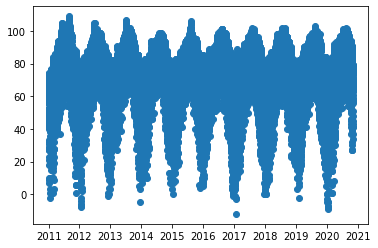

In [57]:
plt.scatter(weather_df_scrub.DATE,weather_df_scrub.TMAX)

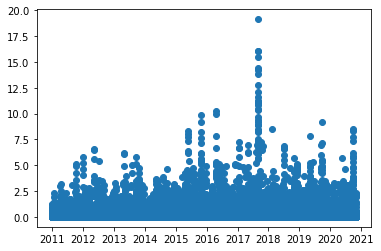

In [58]:
plt.scatter(weather_df_scrub.DATE,weather_df_scrub.PRCP)

In [59]:
#Check for counts of data present for each station
weather_df_scrub.groupby('STATION').count()

,DATE,PRCP,TAVG,TMAX,TMIN,TOBS
STATION,,,,,,
CA001073615,3277,3277,1864,3268,3271,0
US1ARPY0002,2673,2673,0,0,0,0
US1MOFSA215,3286,3286,0,0,0,0
US1MOTX0007,3580,3580,0,0,0,0
US1MOTX0040,1317,1317,0,0,0,0
US1MOTX0041,279,279,0,0,0,0
US1OHSH0011,3376,3376,0,0,0,0
US1TXHRR147,1387,1387,0,0,0,0
US1TXHRR165,1883,1883,0,0,0,0


In [60]:
weather_df_scrub.groupby('DATE').count()

,STATION,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,,
2011-01-01,12,12,0,8,8,1
2011-01-02,12,12,0,8,8,1
2011-01-03,11,11,0,7,7,1
2011-01-04,11,11,0,7,7,1
2011-01-05,11,11,0,7,7,1
...,...,...,...,...,...,...
2020-10-28,21,21,3,9,9,2
2020-10-29,21,21,3,9,9,2
2020-10-30,21,21,3,9,9,2


In [61]:
#Group the data by date and use agg dict to deteremine how to combine the data
weather_agg_dict = {'STATION':'count', 'PRCP':'mean','TAVG':'mean','TMAX':'mean','TMIN':'mean','TOBS':'mean'}
weather_grouped = weather_df_scrub.groupby('DATE')[['STATION','PRCP','TAVG','TMAX','TMIN','TOBS']].agg(weather_agg_dict)
weather_grouped

,STATION,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,,
2011-01-01,12,0.113333,NaN,58.750000,37.625000,46.0
2011-01-02,12,0.000000,NaN,50.375000,31.625000,38.0
2011-01-03,11,0.000000,NaN,57.571429,32.285714,50.0
2011-01-04,11,0.191818,NaN,64.857143,45.428571,64.0
2011-01-05,11,0.163636,NaN,67.857143,46.428571,52.0
...,...,...,...,...,...,...
2020-10-28,21,0.185238,48.333333,57.444444,43.111111,58.0
2020-10-29,21,0.478571,45.666667,61.333333,42.555556,55.0
2020-10-30,21,0.077143,49.666667,62.333333,42.555556,48.0


In [62]:
weather_grouped.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26',
               '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
               '2020-10-31', '2020-11-01'],
              dtype='datetime64[ns]', name='DATE', length=3593, freq=None)

In [63]:
missing_temp = pd.concat([weather_grouped.isnull().sum(), 100 * weather_grouped.isnull().mean()], axis=1)
missing_temp.columns=['count', '%']
missing_temp.sort_values(by='count', ascending=False)

,count,%
TAVG,821,22.849986
STATION,0,0.000000
PRCP,0,0.000000
TMAX,0,0.000000
TMIN,0,0.000000
TOBS,0,0.000000


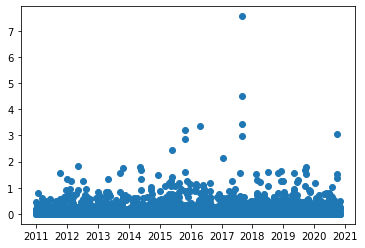

In [64]:
plt.scatter(weather_grouped.index,weather_grouped.PRCP)

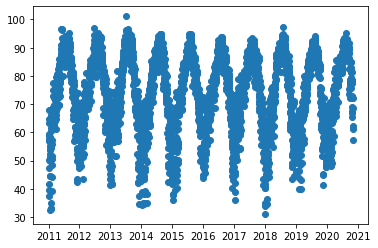

In [65]:
plt.scatter(weather_grouped.index,weather_grouped.TMAX)

In [66]:
weather_df_scrubbed = weather_df_scrub.groupby('DATE').mean()
weather_df_scrubbed

,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,
2011-01-01,0.113333,NaN,58.750000,37.625000,46.0
2011-01-02,0.000000,NaN,50.375000,31.625000,38.0
2011-01-03,0.000000,NaN,57.571429,32.285714,50.0
2011-01-04,0.191818,NaN,64.857143,45.428571,64.0
2011-01-05,0.163636,NaN,67.857143,46.428571,52.0
...,...,...,...,...,...
2020-10-28,0.185238,48.333333,57.444444,43.111111,58.0
2020-10-29,0.478571,45.666667,61.333333,42.555556,55.0
2020-10-30,0.077143,49.666667,62.333333,42.555556,48.0


In [67]:
weather_df_scrubbed.head()

,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,
2011-01-01,0.113333,NaN,58.750000,37.625000,46.0
2011-01-02,0.000000,NaN,50.375000,31.625000,38.0
2011-01-03,0.000000,NaN,57.571429,32.285714,50.0
2011-01-04,0.191818,NaN,64.857143,45.428571,64.0
2011-01-05,0.163636,NaN,67.857143,46.428571,52.0


In [68]:
weather_df_scrubbed.tail()

,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,
2020-10-28,0.185238,48.333333,57.444444,43.111111,58.0
2020-10-29,0.478571,45.666667,61.333333,42.555556,55.0
2020-10-30,0.077143,49.666667,62.333333,42.555556,48.0
2020-10-31,0.003158,52.000000,68.666667,41.000000,47.0
2020-11-01,0.001053,55.000000,72.111111,45.666667,51.0


In [69]:
weather_df_scrubbed.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26',
               '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
               '2020-10-31', '2020-11-01'],
              dtype='datetime64[ns]', name='DATE', length=3593, freq=None)

## Summary of both cleaned DFs

#### This is a summary of the dataframes cleaned.

### Pothole Data

In [70]:
pothole_df_scrubbed.head()

,SR LOCATION,COUNTY,NEIGHBORHOOD,SR TYPE,QUEUE,STATUS,SR CREATE DATE,DUE DATE,DATE CLOSED,OVERDUE,LATITUDE,LONGITUDE,DATE
CASE NUMBER,,,,,,,,,,,,,
11433929-101000452108,Intersection 13500 S POST OAK RD & 5400 WILLOM...,Harris County,CENTRAL SOUTHWEST,Pothole,ROWM_StreetMain,Closed,2011-11-09 06:49:13,2011-11-19 06:49:12,2011-11-22 09:26:28,3.11,29.630333,-95.464071,2011-11-09
11433959-101000452225,"8142 BONNER, HOUSTON TX 77017",HARRIS,MEADOWBROOK / ALLENDALE,Pothole,ROWM_StreetMain,Closed,2011-11-09 08:55:49,2011-11-19 08:55:49,2011-12-01 09:20:03,12.02,29.680578,-95.264047,2011-11-09
11455803-101000452382,"875 LOCKWOOD, HOUSTON TX 77020",Harris,GREATER FIFTH WARD,Pothole,ROWM_StreetMain,Closed,2011-11-09 10:32:12,2011-11-19 10:32:11,2012-01-25 11:25:38,67.04,29.761035,-95.317502,2011-11-09
11434023-101000452387,"875 LOCKWOOD, HOUSTON TX 77020",Harris,GREATER FIFTH WARD,Pothole,ROWM_StreetMain,Closed,2011-11-09 10:35:11,2011-11-19 10:35:10,2011-11-29 12:49:13,10.09,29.761035,-95.317502,2011-11-09
11434047-101000452444,"12501 BRIAR FOREST, HOUSTON TX 77077",HARRIS,BRIAR FOREST,Pothole,ROWM_StreetMain,Closed,2011-11-09 11:09:56,2011-11-19 11:09:56,2011-11-29 13:00:17,10.08,29.753557,-95.602467,2011-11-09


### Weather Data

In [71]:
weather_df_scrubbed.head()

,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,
2011-01-01,0.113333,NaN,58.750000,37.625000,46.0
2011-01-02,0.000000,NaN,50.375000,31.625000,38.0
2011-01-03,0.000000,NaN,57.571429,32.285714,50.0
2011-01-04,0.191818,NaN,64.857143,45.428571,64.0
2011-01-05,0.163636,NaN,67.857143,46.428571,52.0


In [72]:
weather_grouped.head()

,STATION,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,,
2011-01-01,12,0.113333,NaN,58.750000,37.625000,46.0
2011-01-02,12,0.000000,NaN,50.375000,31.625000,38.0
2011-01-03,11,0.000000,NaN,57.571429,32.285714,50.0
2011-01-04,11,0.191818,NaN,64.857143,45.428571,64.0
2011-01-05,11,0.163636,NaN,67.857143,46.428571,52.0


## Extract Data

In [73]:
datapath = '../data'
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [74]:
datapath_pothole = os.path.join(datapath, 'pothole_cleaned.csv')
if not os.path.exists(datapath_pothole):
    pothole_df_scrubbed.to_csv(datapath_pothole, index=False)

In [75]:
datapath_weather = os.path.join(datapath, 'weather_summary.csv')
if not os.path.exists(datapath_weather):
    weather_df_scrubbed.to_csv(datapath_weather, index=False)

# EDA

### Look at Distribution of values

In [76]:
print(pothole_df_scrubbed.shape)
pothole_df_scrubbed.head()

(60483, 13)


,SR LOCATION,COUNTY,NEIGHBORHOOD,SR TYPE,QUEUE,STATUS,SR CREATE DATE,DUE DATE,DATE CLOSED,OVERDUE,LATITUDE,LONGITUDE,DATE
CASE NUMBER,,,,,,,,,,,,,
11433929-101000452108,Intersection 13500 S POST OAK RD & 5400 WILLOM...,Harris County,CENTRAL SOUTHWEST,Pothole,ROWM_StreetMain,Closed,2011-11-09 06:49:13,2011-11-19 06:49:12,2011-11-22 09:26:28,3.11,29.630333,-95.464071,2011-11-09
11433959-101000452225,"8142 BONNER, HOUSTON TX 77017",HARRIS,MEADOWBROOK / ALLENDALE,Pothole,ROWM_StreetMain,Closed,2011-11-09 08:55:49,2011-11-19 08:55:49,2011-12-01 09:20:03,12.02,29.680578,-95.264047,2011-11-09
11455803-101000452382,"875 LOCKWOOD, HOUSTON TX 77020",Harris,GREATER FIFTH WARD,Pothole,ROWM_StreetMain,Closed,2011-11-09 10:32:12,2011-11-19 10:32:11,2012-01-25 11:25:38,67.04,29.761035,-95.317502,2011-11-09
11434023-101000452387,"875 LOCKWOOD, HOUSTON TX 77020",Harris,GREATER FIFTH WARD,Pothole,ROWM_StreetMain,Closed,2011-11-09 10:35:11,2011-11-19 10:35:10,2011-11-29 12:49:13,10.09,29.761035,-95.317502,2011-11-09
11434047-101000452444,"12501 BRIAR FOREST, HOUSTON TX 77077",HARRIS,BRIAR FOREST,Pothole,ROWM_StreetMain,Closed,2011-11-09 11:09:56,2011-11-19 11:09:56,2011-11-29 13:00:17,10.08,29.753557,-95.602467,2011-11-09


In [77]:
pothole_df_scrubbed.DATE.min()

datetime.date(2011, 11, 9)

In [78]:
print(weather_df_scrubbed.shape)
weather_df_scrubbed.head()

(3593, 5)


,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,
2011-01-01,0.113333,NaN,58.750000,37.625000,46.0
2011-01-02,0.000000,NaN,50.375000,31.625000,38.0
2011-01-03,0.000000,NaN,57.571429,32.285714,50.0
2011-01-04,0.191818,NaN,64.857143,45.428571,64.0
2011-01-05,0.163636,NaN,67.857143,46.428571,52.0


In [79]:
weather_df_scrubbed.describe()

,PRCP,TAVG,TMAX,TMIN,TOBS
count,3593.000000,2772.000000,3593.000000,3593.000000,3593.000000
mean,0.139037,64.405303,74.179527,54.471626,59.137907
std,0.297666,13.260624,13.562602,13.778004,14.718355
min,0.000000,23.666667,31.100000,16.900000,8.000000
25%,0.005238,55.000000,64.333333,43.375000,48.333333
50%,0.041053,66.666667,75.900000,56.300000,62.000000
75%,0.154286,75.333333,86.000000,67.300000,71.333333
max,7.560455,90.000000,101.142857,76.428571,85.000000


In [80]:
pothole_group = pothole_df_scrubbed.groupby('DATE')['SR CREATE DATE'].count()
pothole_group.size

3468

In [81]:
combined = weather_df_scrubbed.join(pothole_group,how='inner')
combined.shape

(3252, 6)

In [82]:
combined.head()

,PRCP,TAVG,TMAX,TMIN,TOBS,SR CREATE DATE
DATE,,,,,,
2011-11-09,0.347692,NaN,62.000000,46.125000,53.0,11
2011-11-10,0.017857,NaN,57.777778,37.888889,42.0,17
2011-11-11,0.111429,NaN,58.888889,33.888889,52.0,1
2011-11-12,0.000000,NaN,66.888889,41.111111,67.0,1
2011-11-13,0.007857,NaN,69.777778,52.888889,71.0,2


In [83]:
combined = combined.rename({'SR CREATE DATE':'POTHOLE COUNT'}, axis='columns')

In [84]:
combined.head()

,PRCP,TAVG,TMAX,TMIN,TOBS,POTHOLE COUNT
DATE,,,,,,
2011-11-09,0.347692,NaN,62.000000,46.125000,53.0,11
2011-11-10,0.017857,NaN,57.777778,37.888889,42.0,17
2011-11-11,0.111429,NaN,58.888889,33.888889,52.0,1
2011-11-12,0.000000,NaN,66.888889,41.111111,67.0,1
2011-11-13,0.007857,NaN,69.777778,52.888889,71.0,2


In [85]:
combined.corr()

,PRCP,TAVG,TMAX,TMIN,TOBS,POTHOLE COUNT
PRCP,1.000000,0.040386,0.018409,0.096624,0.076583,-0.042758
TAVG,0.040386,1.000000,0.923235,0.913122,0.857968,-0.186505
TMAX,0.018409,0.923235,1.000000,0.945378,0.869318,-0.164412
TMIN,0.096624,0.913122,0.945378,1.000000,0.900276,-0.169966
TOBS,0.076583,0.857968,0.869318,0.900276,1.000000,-0.217257
POTHOLE COUNT,-0.042758,-0.186505,-0.164412,-0.169966,-0.217257,1.000000


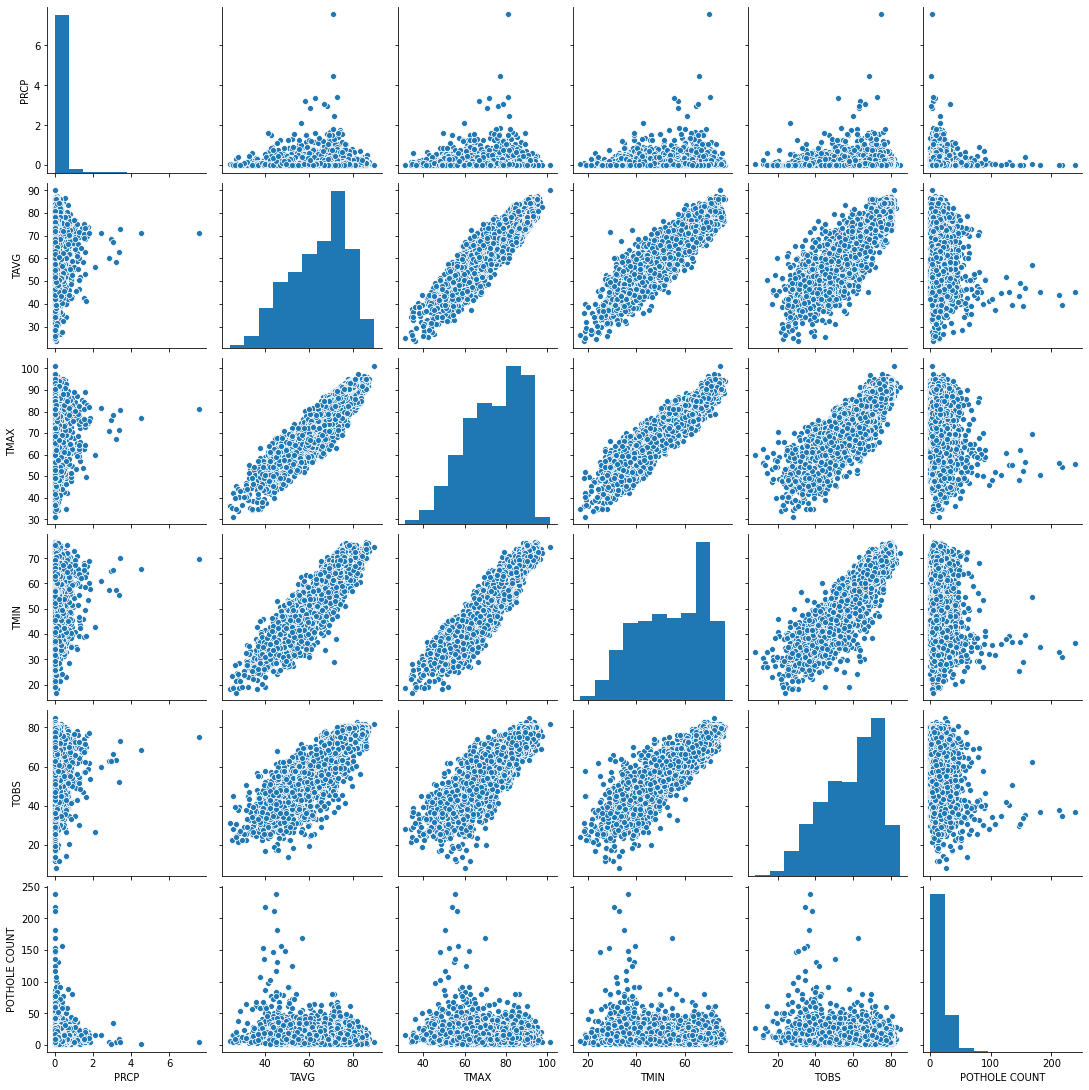

In [86]:
sns.pairplot(combined)

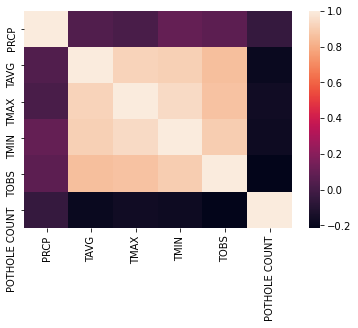

In [87]:
sns.heatmap(combined.corr())

[None, None]

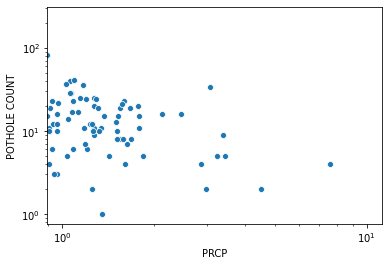

In [88]:
plot = sns.scatterplot(data=combined, x='PRCP',y='POTHOLE COUNT')
plot.set(xscale='log',yscale='log')

### Attempt analyis by neighborhood since general PRCP to pothole count showed a low correlation

In [89]:
pothole_df_scrubbed.NEIGHBORHOOD.unique()

array(['CENTRAL SOUTHWEST', 'MEADOWBROOK / ALLENDALE',
       'GREATER FIFTH WARD', 'BRIAR FOREST', 'ALIEF', 'MEYERLAND AREA',
       'CLINTON PARK TRI-COMMUNITY', 'ELDRIDGE / WEST OAKS',
       'UNIVERSITY PLACE', 'GREATER INWOOD', 'NEARTOWN - MONTROSE',
       'TRINITY / HOUSTON GARDENS', 'SHARPSTOWN', 'BRAEBURN', 'WESTCHASE',
       'SPRING BRANCH EAST', 'GREATER THIRD WARD', 'GREATER EASTWOOD',
       'SOUTH MAIN', 'WASHINGTON AVENUE COALITION / MEMORIAL P',
       'GREENWAY / UPPER KIRBY AREA', 'SOUTH BELT / ELLINGTON',
       'AFTON OAKS / RIVER OAKS AREA', 'GOLFCREST / BELLFORT / REVEILLE',
       'CENTRAL NORTHWEST', 'SUNNYSIDE', 'ADDICKS PARK TEN', 'MIDTOWN',
       'CLEAR LAKE', 'GREATER HEIGHTS', 'DOWNTOWN',
       'GREATER OST / SOUTH UNION', nan, 'GREATER UPTOWN',
       'IAH / AIRPORT AREA', 'SPRING BRANCH CENTRAL', 'MINNETEX',
       'DENVER HARBOR / PORT HOUSTON', 'NORTHSIDE/NORTHLINE', 'MEMORIAL',
       'SECOND WARD', 'FAIRBANKS / NORTHWEST CROSSING', 'NEAR NORTHSIDE'

In [90]:
pothole_new = pothole_df_scrubbed.reset_index()
pothole_new['DATE2'] = pothole_new['DATE']

In [91]:
pothole_group2 = pothole_new.groupby(['NEIGHBORHOOD','DATE'])['DATE2'].count()

In [92]:
pothole_group2.head()

NEIGHBORHOOD  DATE      
ACRES HOME    2011-11-29    1
              2011-12-06    1
              2011-12-29    1
              2012-01-05    1
              2012-01-10    1
Name: DATE2, dtype: int64

In [93]:
PT = pothole_group2.unstack(level='DATE').T
PT.sort_index()

NEIGHBORHOOD,ACRES HOME,ADDICKS PARK TEN,AFTON OAKS / RIVER OAKS AREA,ALIEF,ASTRODOME AREA,BRAEBURN,BRAESWOOD,BRAESWOOD PLACE,BRAYS OAKS,BRIAR FOREST,...,SUNNYSIDE,TRINITY / HOUSTON GARDENS,UNIVERSITY PLACE,WASHINGTON AVENUE COALITION / MEMORIAL P,WESTBRANCH,WESTBURY,WESTCHASE,WESTWOOD,WILLOW MEADOWS / WILLOWBEND AREA,WILLOWBROOK
DATE,,,,,,,,,,,,,,,,,,,,,
2011-11-09,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-10,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2011-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-04,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,2.0,1.0,...,1.0,NaN,2.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN
2021-06-05,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN


In [94]:
combined2 = weather_df_scrubbed.join(PT,how='inner')

In [95]:
combined2.head()

,PRCP,TAVG,TMAX,TMIN,TOBS,ACRES HOME,ADDICKS PARK TEN,AFTON OAKS / RIVER OAKS AREA,ALIEF,ASTRODOME AREA,...,SUNNYSIDE,TRINITY / HOUSTON GARDENS,UNIVERSITY PLACE,WASHINGTON AVENUE COALITION / MEMORIAL P,WESTBRANCH,WESTBURY,WESTCHASE,WESTWOOD,WILLOW MEADOWS / WILLOWBEND AREA,WILLOWBROOK
DATE,,,,,,,,,,,,,,,,,,,,,
2011-11-09,0.347692,NaN,62.000000,46.125000,53.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-10,0.017857,NaN,57.777778,37.888889,42.0,NaN,NaN,NaN,3.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2011-11-11,0.111429,NaN,58.888889,33.888889,52.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-12,0.000000,NaN,66.888889,41.111111,67.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-13,0.007857,NaN,69.777778,52.888889,71.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


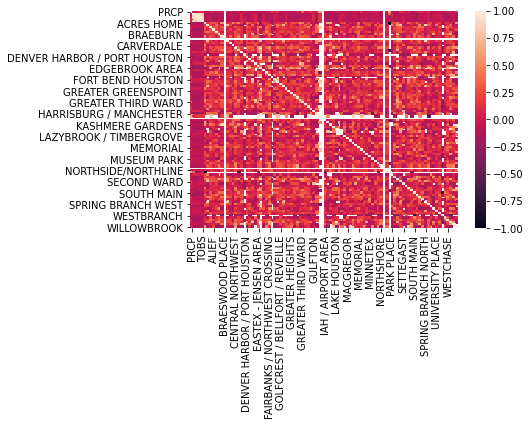

In [96]:
sns.heatmap(combined2.corr())

In [97]:
combined2_corr = combined2.corr()
combined2_corr.PRCP.sort_values(ascending=False)

PRCP                  1.000000
OST / SOUTH UNION     0.682243
HIDDEN VALLEY         0.631251
GREATER THIRD WARD    0.339245
FONDREN GARDENS       0.182810
                        ...   
ADDICKS PARK TEN     -0.110962
CARVERDALE           -0.126062
BRAESWOOD PLACE            NaN
HUNTERWOOD                 NaN
NORTHSIDE VILLAGE          NaN
Name: PRCP, Length: 96, dtype: float64

In [98]:
combined2_corr.TOBS.sort_values(ascending=False)

TOBS                       1.000000
TMIN                       0.900311
TMAX                       0.869373
TAVG                       0.857968
HIDDEN VALLEY              0.137259
                             ...   
EDGEBROOK AREA            -0.232153
HARRISBURG / MANCHESTER   -0.286571
BRAESWOOD PLACE                 NaN
HUNTERWOOD                      NaN
NORTHSIDE VILLAGE               NaN
Name: TOBS, Length: 96, dtype: float64

### OST/South Union and Hidden Valley showed the strongest correlation between PRCP and Pothole Reported count with pearson values of 0.68 and 0.63

## PreProcessing and Training

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scale = StandardScaler()
names = combined.columns
#scaled_combined = scale.fit_transform(combined)
#scaled_combined = pd.DataFrame(scaled_combined, columns=names)
y = combined['POTHOLE COUNT'].values
X = combined.drop('POTHOLE COUNT', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)

### Proceeding ahead for practice as data does not appear correlated. 
#### No categories so proceeded to standardize the data and split it for training purposes. 

## Modelling

In [121]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer

#### Linear Regression

In [124]:
k = [k+1 for k in range(len(X_train[0]))]
grid_params = {'selectkbest__k': k}
lr_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                        StandardScaler(),
                        SelectKBest(score_func = f_regression),
                        LinearRegression())
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [127]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(9.435704527988841, 0.26664890290230286)

#### Random Forest

In [130]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {'randomforestregressor__n_estimators': n_est}
rf_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                        StandardScaler(),
                        RandomForestRegressor(random_state=47))
rf_grid_cv = GridSearchCV(rf_pipe, param_grid=grid_params, cv= 5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [131]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(9.959174432234432, 0.331863424227371)

#### Logistic Regression

In [132]:
k = [k+1 for k in range(len(X_train[0]))]
grid_params = {'selectkbest__k': k}
lg_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                        StandardScaler(),
                        SelectKBest(score_func = f_regression),
                        LogisticRegression())
lg_grid_cv = GridSearchCV(lg_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lg_grid_cv.fit(X_train, y_train)
lg_neg_mae = cross_validate(lg_grid_cv.best_estimator_, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

C:\Users\Pierre\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Pierre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pierre\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [133]:
lg_mae_mean = np.mean(-1 * lg_neg_mae['test_score'])
lg_mae_std = np.std(-1 * lg_neg_mae['test_score'])
lg_mae_mean, lg_mae_std

(10.1525014459225, 0.4298962042055948)

### Choosing Model

With a lower mean and standard deviation, the linear regression model was selected